## Работа с временными рядами

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

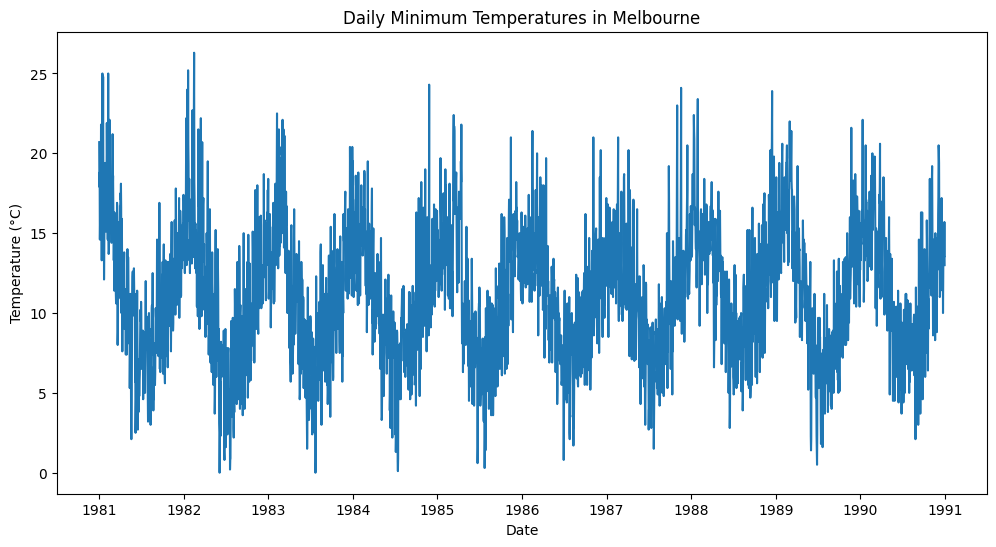

In [3]:

# Загрузка и визуализация предоставленного датасета с минимальными температурами
file_path = 'daily-min-temperatures.csv'

# Чтение данных из файла CSV
data = pd.read_csv(file_path)

# Преобразование столбца даты в формат datetime
data['Date'] = pd.to_datetime(data['Date'])

# Установка столбца даты в качестве индекса
data.set_index('Date', inplace=True)

# Визуализация данных
plt.figure(figsize=(12, 6))
plt.plot(data['Temp'])
plt.title('Daily Minimum Temperatures in Melbourne')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()


### Характеристики временного ряда


**Тренд** временного ряда - это медленные изменения параметров исследуемого процесса;

**Сезонность** - влияния периодичности (день недели, время года и т.д.);

**Шум** - это случайные факторы.


Пример: Известно, что в среднем луна каждый год отдаляется на 4 см - это тренд, в течение дня луна совершает оборот вокруг земли и расстояние колеблется от ~362600 км до ~405400 км - это сезонность. Шум - это "случайные" факторы, например, влияние других планет. Если мы изобразим сумму этих трёх графиков, то мы получим временной ряд - функцию, показывающую изменение расстояния от земли до луны во времени.

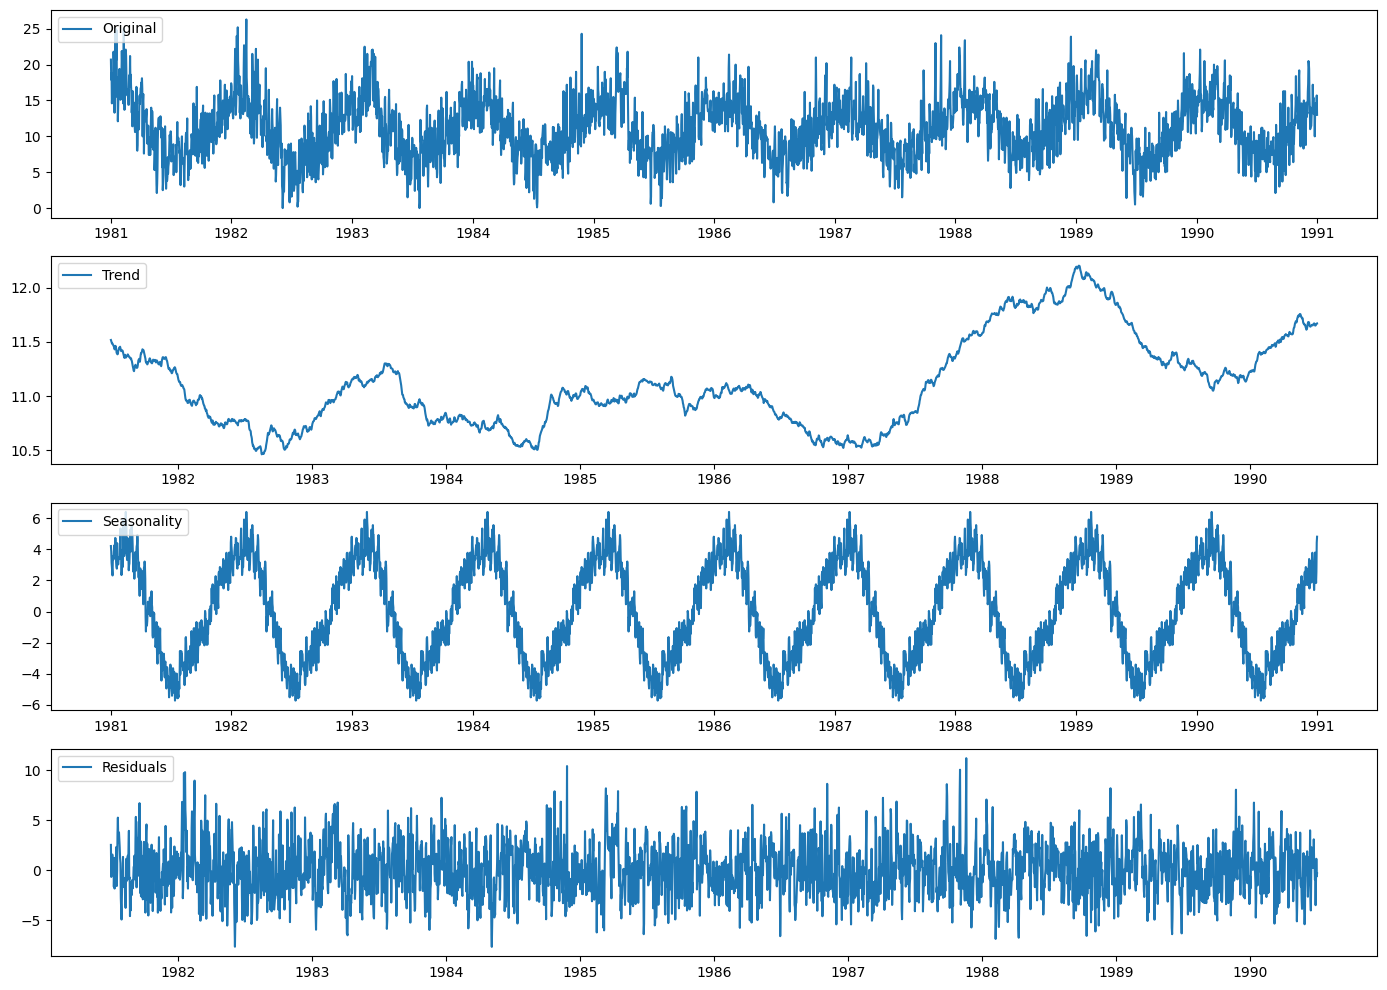

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Декомпозиция временного ряда на тренд, сезонность и остатки
decomposition = seasonal_decompose(data['Temp'], model='additive', period=365)

# Создание графиков для декомпозиции
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data['Temp'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Автокорреялция и частичная автокорреляция

**Автокорреляция** показывает на сколько значение временного ряда At зависит от значения временного ряд A(t-k)(k - лаг). Т.е. другими словами мы понимаем на сколько каждое предыдущие значиение вносит вклад в итоговое At. Но есть проблема!

При таком подходе мы не учитываем влияние промежуточных значений.

Т.е. A(t-k-1), A(t-k-2), A(t-k-3) влияют на A(t-k) и вместе с этим влияют на A(t).

Если мы хотим узнать чистую корреляцию, то нужно считать частичную автокорреляцию

**Частичная автокорреляция**- это сводка взаимосвязи между наблюдением во временном ряду с наблюдениями на предыдущих временных этапах с удалением взаимосвязей между промежуточными наблюдениями.

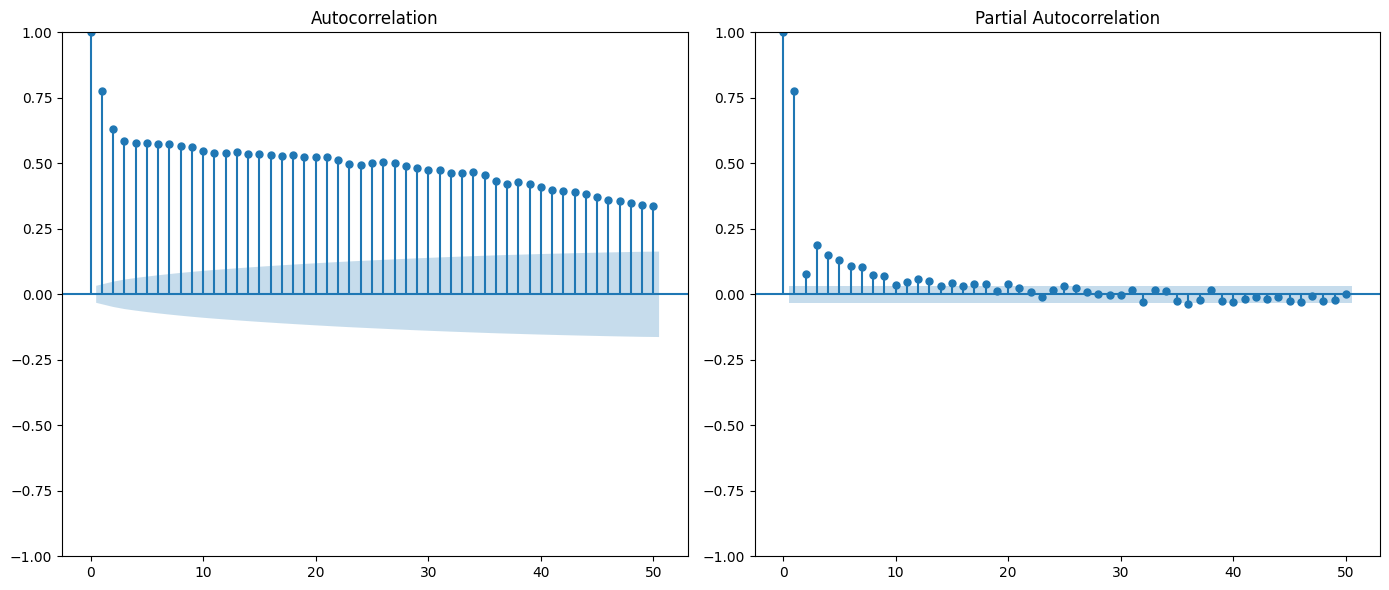

In [5]:
# Графики автокорреляции (ACF) и частичной автокорреляции (PACF)
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(data['Temp'], ax=plt.gca(), lags=50)

plt.subplot(122)
plot_pacf(data['Temp'], ax=plt.gca(), lags=50)

plt.tight_layout()
plt.show()

### Проверка на стационарность и стабилизация

**Стационарный процесс** — это стохастический процесс, у которого не изменяется распределение вероятности при смещении во времени.


Временной ряд Yt называется слабо стационарным ( стационарным в широком смысле, weak stationary), если его теоретические математическое ожидание и дисперсия не зависят от времени, и если теоретическая ковариация(мера линейной зависимости) между его значениями в моменты времени t и t+s зависят только от s, но не от t.

**Статистические тесты на стационарность**
Тест Дикки-Фуллера (проверка на единичный корень)



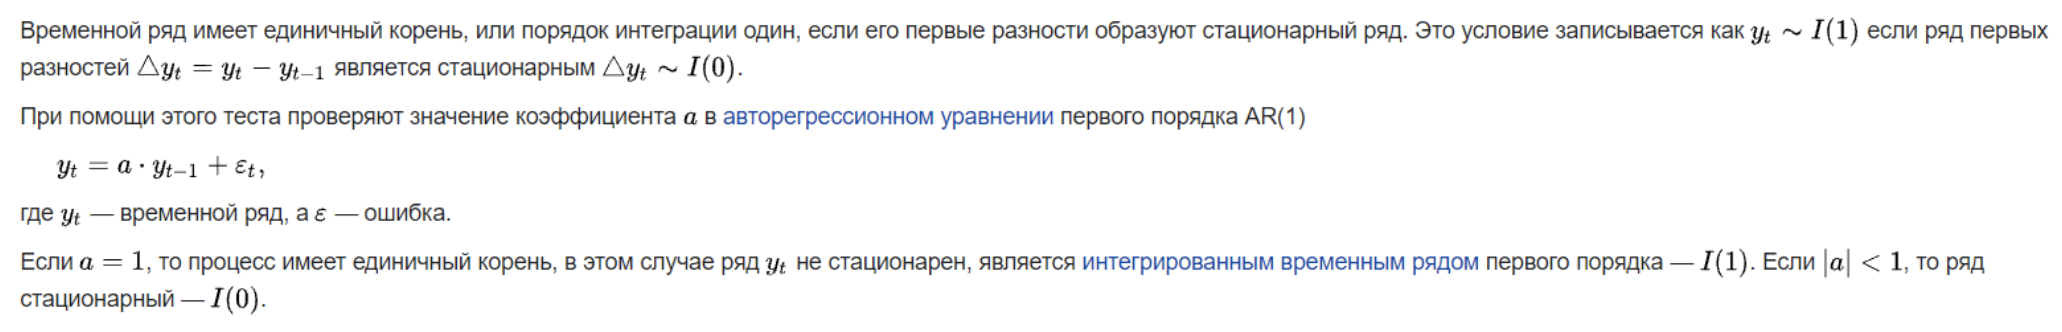

In [9]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

# Тест Дики-Фуллера для проверки стационарности
dickey_fuller_test = adfuller(data['Temp'])
df_result = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in dickey_fuller_test[4].items():
    df_result[f'Critical Value ({key})'] = value

# Вывод результатов теста Дики-Фуллера и значения лямбда для теста Бокса-Кокса
df_result


Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64

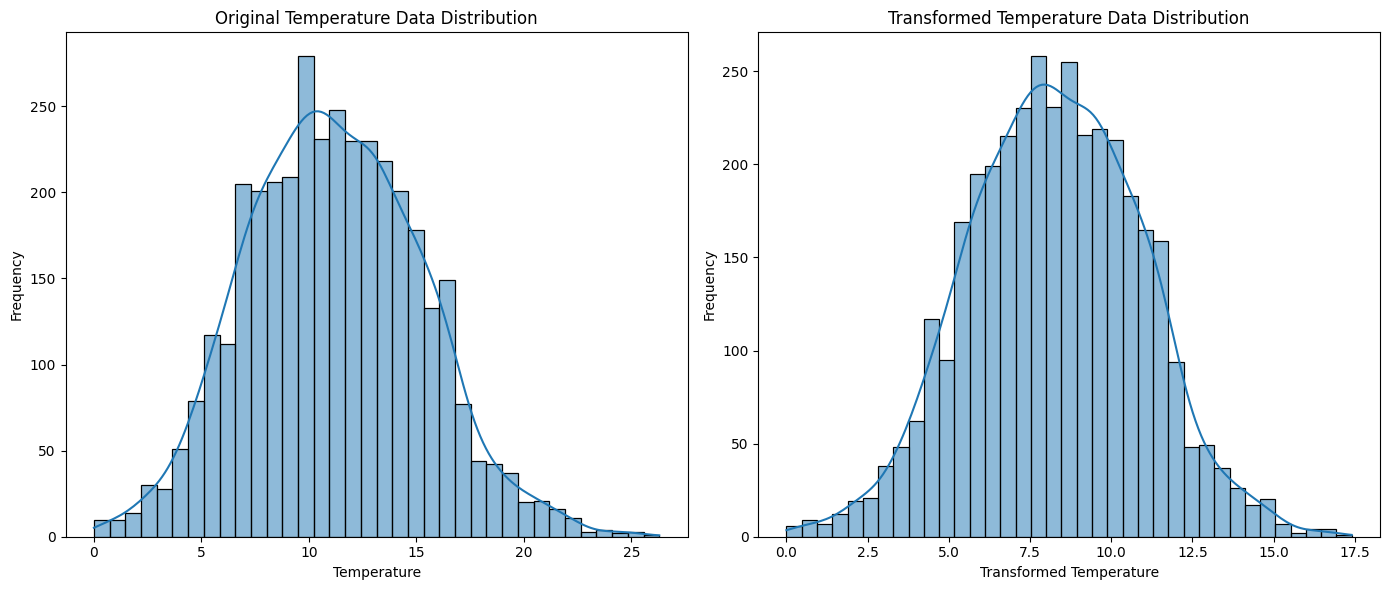

In [8]:
import seaborn as sns

# Применение теста Бокса-Кокса для стабилизации дисперсии

# Перемещение данных о температуре, чтобы все значения были положительными
min_temp = data['Temp'].min()
data['Temp_positive'] = data['Temp'] - min_temp + 1  # Добавляем 1, чтобы гарантировать положительность

# Применение теста Бокса-Кокса к нормализованным данным
data['Temp_transformed'], lambda_value = boxcox(data['Temp_positive'])
lambda_value = round(lambda_value, 2)

# График распределения оригинальных и преобразованных данных
plt.figure(figsize=(14, 6))

# График распределения оригинальных данных
plt.subplot(121)
sns.histplot(data['Temp'], kde=True)
plt.title('Original Temperature Data Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# График распределения данных после преобразования Бокса-Кокса
plt.subplot(122)
sns.histplot(data['Temp_transformed'], kde=True)
plt.title('Transformed Temperature Data Distribution')
plt.xlabel('Transformed Temperature')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Слева:** График распределения исходных данных о температуре. Здесь видно, что распределение имеет некоторые асимметричные характеристики и отклонения от нормальности.


**Справа:** График распределения данных после применения преобразования Бокса-Кокса. Преобразование сделало распределение более симметричным и приближенным к нормальному.

### Фурье преобразование

На графике показано преобразование Фурье для данных о минимальных температурах. График представляет собой спектр мощности, который показывает, какие частоты присутствуют в данных и насколько они сильны. Ось x показывает частоту в единицах на год, а ось y представляет мощность в децибелах.

**Левая колонка:** Показывает сглаженные данные о температуре. Каждый график соответствует скользящему среднему с разным размером окна (7, 30 и 90 дней). Меньшие окна сохраняют больше деталей исходного временного ряда, в то время как большие окна обеспечивают более гладкое представление.

**Правая колонка:** Отображает преобразования Фурье для каждого набора сглаженных данных. Эти графики показывают спектр мощности, отражающий важность различных частотных компонентов в данных. С увеличением размера окна скользящего среднего наблюдается уменьшение высокочастотных компонентов и усиление низкочастотных, что соответствует более гладкому тренду в данных.

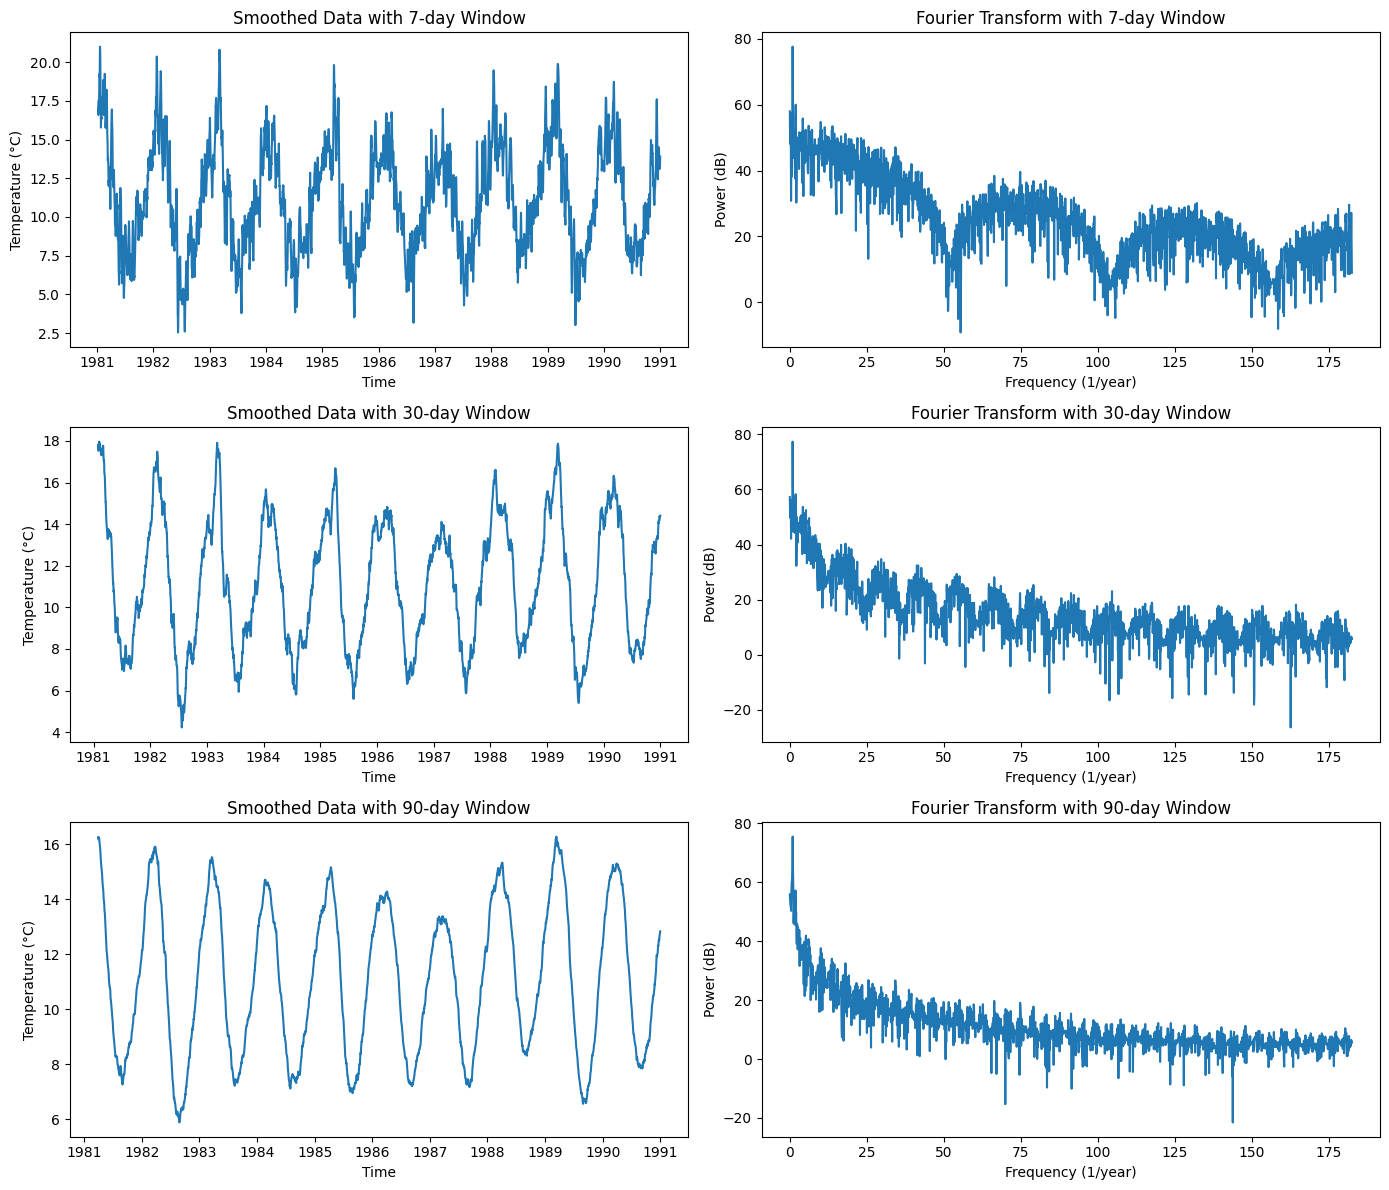

In [13]:

import numpy as np
from scipy.fft import fft

# Преобразование сглаженных данных DataFrame в массивы numpy
smoothed_arrays = [smoothed_temp.dropna().to_numpy() for smoothed_temp in smoothed_data]

# Вычисление преобразования Фурье для каждого набора сглаженных данных
fft_data = [fft(smoothed_array) for smoothed_array in smoothed_arrays]
fft_psd = [np.abs(fft_array) ** 2 for fft_array in fft_data]
fftfreq = [np.fft.fftfreq(len(psd), 1. / 365) for psd in fft_psd]

# Визуализация сглаженных данных и соответствующих Фурье-преобразований
plt.figure(figsize=(14, 12))

for i in range(len(window_sizes)):
    # График сглаженных данных
    plt.subplot(len(window_sizes), 2, 2 * i + 1)
    plt.plot(smoothed_data[i])
    plt.title(f'Smoothed Data with {window_sizes[i]}-day Window')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')

    # График Фурье-преобразования
    plt.subplot(len(window_sizes), 2, 2 * i + 2)
    freq = fftfreq[i]
    psd = fft_psd[i]
    plt.plot(freq[freq > 0], 10 * np.log10(psd[freq > 0]))
    plt.title(f'Fourier Transform with {window_sizes[i]}-day Window')
    plt.xlabel('Frequency (1/year)')
    plt.ylabel('Power (dB)')

plt.tight_layout()
plt.show()


### Вейвлет преобразование

Вейвлет-преобразование позволяет разложить временной ряд на аппроксимации (cA) и детали (cD). Аппроксимации представляют низкочастотные компоненты данных (общий тренд), а детали отражают высокочастотные компоненты (например, шум или более мелкие колебания).

Вейвлет-преобразование можно выполнять на нескольких уровнях, где на каждом уровне временной ряд разделяется на более детальные аппроксимации и детали. Это позволяет анализировать данные на разных масштабах.



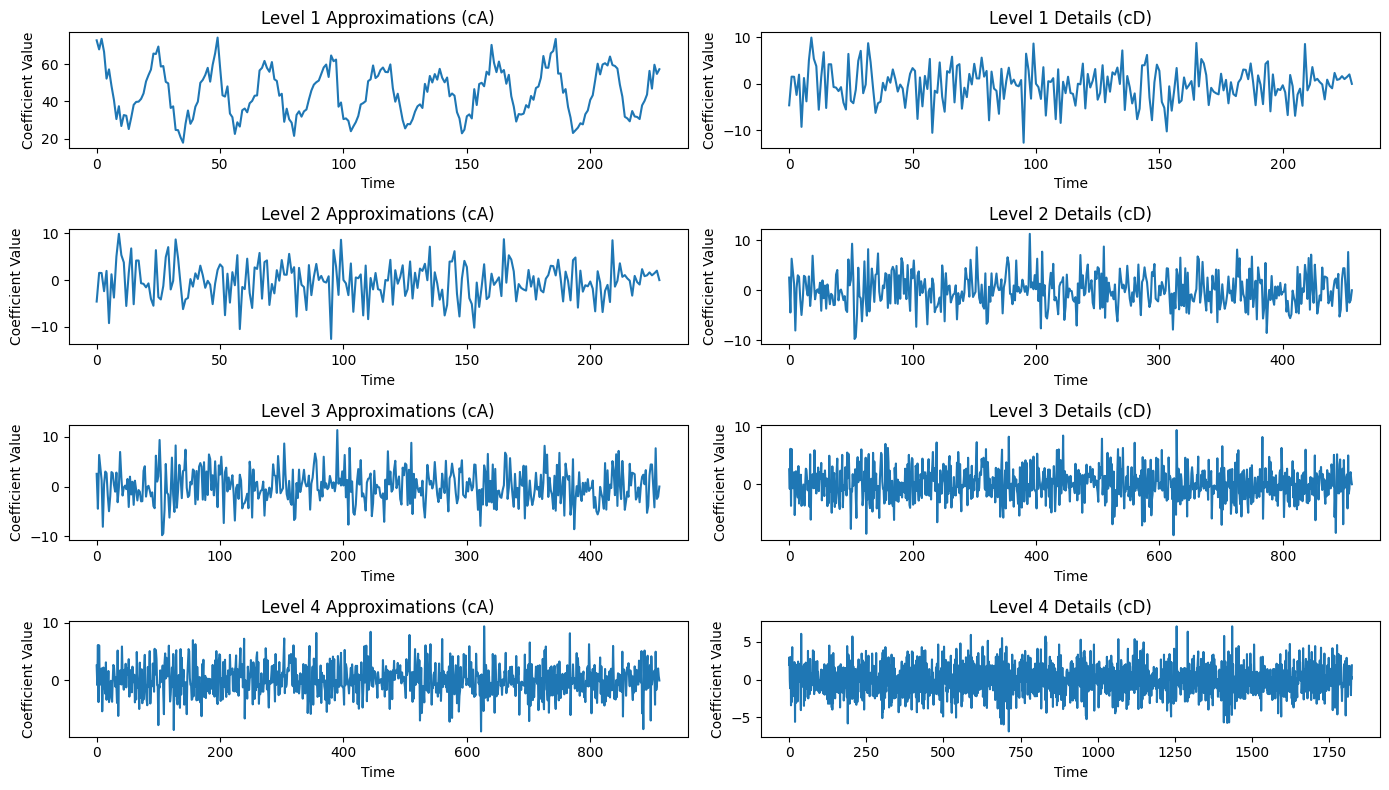

In [15]:
import pywt
# Выбор количества уровней для вейвлет-преобразования
levels = 4

# Выполнение вейвлет-преобразования на разных уровнях
wavelet = 'haar'
coefficients = pywt.wavedec(data['Temp'], wavelet, level=levels)

# Визуализация результатов вейвлет-преобразования на разных уровнях
plt.figure(figsize=(14, 2 * levels))

for i in range(levels):
    # График аппроксимаций на уровне i
    plt.subplot(levels, 2, 2 * i + 1)
    plt.plot(coefficients[i])
    plt.title(f'Level {i+1} Approximations (cA)')
    plt.xlabel('Time')
    plt.ylabel('Coefficient Value')

    # График деталей на уровне i
    plt.subplot(levels, 2, 2 * i + 2)
    plt.plot(coefficients[i+1])
    plt.title(f'Level {i+1} Details (cD)')
    plt.xlabel('Time')
    plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.show()
